In [2]:
import random, requests, hashlib, base64, time
import json
import re
#from HTMLParser import HTMLParser
from bs4 import BeautifulSoup, NavigableString, Tag
from bs4 import BeautifulSoup as BS
from bs4 import Comment
import csv
import sys
import unicodedata
import datetime
#import arrow
import urllib
import pandas as pd
import numpy as np
import urllib
import urllib.request
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib as mpl


In [157]:
reader = pd.read_csv("datasets/companies_sorted.csv",low_memory=True, chunksize=10**4)
df = pd.concat([x for x in reader], ignore_index=True)
df['size range'] = pd.Categorical(df['size range'], ["1 - 10", "11 - 50", "51 - 200", "201 - 500", "501 - 1000", "1001 - 5000", "5001 - 10000", "10001+"])
df['country'].fillna('missing',inplace = True)
df['industry'].fillna('missing',inplace = True)
print('complete')

complete


In [159]:
df.sort_values(by='current employee estimate', ascending=False).head()

,Unnamed: 0,name,domain,year founded,industry,size range,locality,country,linkedin url,current employee estimate,total employee estimate
0,5872184,ibm,ibm.com,1911.0,information technology and services,10001+,"new york, new york, united states",united states,linkedin.com/company/ibm,274047,716906
1,4425416,tata consultancy services,tcs.com,1968.0,information technology and services,10001+,"bombay, maharashtra, india",india,linkedin.com/company/tata-consultancy-services,190771,341369
2,21074,accenture,accenture.com,1989.0,information technology and services,10001+,"dublin, dublin, ireland",ireland,linkedin.com/company/accenture,190689,455768
3,2309813,us army,goarmy.com,1800.0,military,10001+,"alexandria, virginia, united states",united states,linkedin.com/company/us-army,162163,445958
4,1558607,ey,ey.com,1989.0,accounting,10001+,"london, greater london, united kingdom",united kingdom,linkedin.com/company/ernstandyoung,158363,428960


In [158]:
#value counts
print(df['size range'].value_counts(normalize=True))
print()
print(df['country'].value_counts(normalize=True))
print()
print(df['industry'].value_counts())
print()
print(df['industry'].value_counts(normalize=True))
print()
print(df[df['country'] == 'united kingdom']['locality'].value_counts(normalize=True))
print()
print(df[df['country'] == 'united states']['locality'].value_counts(normalize=True))
#print()
#print(df['year founded'].value_counts(bins=10))
#print()
#print(df['current employee estimate'].value_counts(bins=10))

1 - 10          0.778624
11 - 50         0.157053
51 - 200        0.045286
201 - 500       0.010942
501 - 1000      0.003958
1001 - 5000     0.003421
5001 - 10000    0.000424
10001+          0.000292
Name: size range, dtype: float64

missing                      3.274875e-01
united states                3.176817e-01
united kingdom               7.137022e-02
canada                       2.601560e-02
india                        2.013599e-02
                                 ...     
saint helena                 1.394034e-07
u.s. virgin islands          1.394034e-07
niue                         1.394034e-07
saint pierre and miquelon    1.394034e-07
saint barthélemy             1.394034e-07
Name: country, Length: 237, dtype: float64

information technology and services    453044
marketing and advertising              338162
missing                                290003
construction                           257921
management consulting                  194556
                              

In [187]:
df['is_ss'] = np.nan
#df.at[4831970, 'is_ss']
ss_companies = ['wyrd-games.net', 'fashionforward.ae', 'yespers.com', 'hopcreative.com', 'rodarte.net', 'fotio', 'latent image', 'aesthetic distance', 'dan carter advisors plc', '18 hubbard street llc', 'advanced derma laser tech', 'belton church of christ', 'monroe covenant church']
for i in ss_companies:
    if ".net" in i or ".com" in i or ".ae" in i:
        df.loc[df['domain'] == i, 'is_ss'] = 1
    else:
        df.loc[df['name'] == i, 'is_ss'] = 1
    
    #df[df['name'] == 'fotio']['is_ss'] = 1

df[df['is_ss'] == 1]
#df.head()#df[df['name'].str.contains('fotio', na=False, regex=False)]

,Unnamed: 0,name,domain,year founded,industry,size range,locality,country,linkedin url,current employee estimate,total employee estimate,is_ss
794186,6170937,fashion forward dubai,fashionforward.ae,2012.0,apparel & fashion,11 - 50,"dubai, dubai, united arab emirates",united arab emirates,linkedin.com/company/fashion-forward-me,10,54,1.0
851306,6528264,"wyrd miniatures, llc",wyrd-games.net,2005.0,consumer goods,11 - 50,"kennesaw, georgia, united states",united states,linkedin.com/company/wyrd-miniatures-llc,9,20,1.0
2686564,3944894,rodarte,rodarte.net,2005.0,luxury goods & jewelry,1 - 10,"los angeles, california, united states",united states,linkedin.com/company/rodarte,2,21,1.0
2775244,6695843,hop creative,hopcreative.com,2009.0,design,1 - 10,NaN,missing,linkedin.com/company/hop-creative,2,2,1.0
2968302,2719919,yespers,yespers.com,2014.0,food & beverages,1 - 10,"giethoorn, overijssel, netherlands",netherlands,linkedin.com/company/yespers,2,5,1.0
4831970,689172,fotio,fotio.co,2012.0,photography,1 - 10,NaN,missing,linkedin.com/company/fotio,1,1,1.0
6198076,137457,advanced derma laser tech,advanceddermalaser.com,1999.0,cosmetics,1 - 10,"new york, new york, united states",united states,linkedin.com/company/advanced-derma-laser-tech...,0,1,1.0
6198095,137591,belton church of christ,beltonchurch.com,NaN,religious institutions,1 - 10,"belton, missouri, united states",united states,linkedin.com/company/belton-church-of-christ,0,1,1.0
6198272,2808661,latent image,latentimage.dk,NaN,media production,1 - 10,"seattle, washington, united states",united states,linkedin.com/company/latent-image,0,1,1.0
6198339,7078337,aesthetic distance,aestheticdistance.com,NaN,missing,1 - 10,NaN,missing,linkedin.com/company/aesthetic-distance,0,1,1.0


In [120]:
#df[df['name'].isin(['egg shop'])]
df[df['domain'].str.contains('jasminedowling', na=False, regex=False)]
#df.head()#df[df['name'].str.contains('fotio', na=False, regex=False)]

,Unnamed: 0,name,domain,year founded,industry,size range,locality,country,linkedin url,current employee estimate,total employee estimate,is_ss


In [94]:
for row in df[df.index <= 5].itertuples():
    print(row.Index, row.domain)

0 ibm.com
1 tcs.com
2 accenture.com
3 goarmy.com
4 ey.com
5 hpe.com


In [ ]:
#print(df[df.index < 10
dfa = df
dfa = df[df['name'] == 'fotio']
df = df.sort_values(by='current employee estimate', ascending=True).reset_index(drop=True)
#print(df)
adjustment = 1000 + 5000
counter = adjustment
for row in df[(df.index >= counter) & (df.index < counter + 10) ].itertuples():
    if row.domain == 'nan':
        continue
    else:
        try:
            url2 ='https://' + str(row.domain)
            url = urllib.request.urlopen(url2)
            s = url.read()
            soup = BeautifulSoup(s, 'html.parser')
            comments = soup.find_all(string=lambda text: isinstance(text, Comment))
            #print('start')
            for c in comments:
                if "Squarespace" in c:
                    print(str(i.name) + ": YESS")
                    df.at[row.Index, 'is_ss'] = 1
                    break
            #print(url2)                
            #print('finish')    


        except:
            try:
                url2 ='http://' + str(row.domain)
                #print(url2)
                url = urllib.request.urlopen(url2)
                s = url.read()
                soup = BeautifulSoup(s, 'html.parser')
                comments = soup.find_all(string=lambda text: isinstance(text, Comment))
                for c in comments:
                    if "Squarespace" in c:
                        print(str(i.name) + ": YESS")
                        df.at[row.Index, 'is_ss'] = 1
                        break
            except:
                pass
        
    counter += 1
    if counter == 1 + adjustment:
        print(counter)
    elif counter == 10 + adjustment:
        print(counter)
    elif counter == 100 + adjustment:
        print(counter)
    elif counter == 500 + adjustment:
        print(counter)
    elif counter == 1000 + adjustment:
        print(counter)
    elif counter % 10000 == 0:
        print(counter)
    elif counter % 100000 == 0:
        print(counter)
        
     

6001
6010
6100


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


6500
7000


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
C:\Users\cccnyc1dbl\AppData\Local\Continuum\anaconda32\lib\site-packages\bs4\__init__.py:294: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


In [ ]:
df[(df['is_ss'] == 1) | (df['name'] == 'fotio')]

In [ ]:
url2= 'https://www.fotio.co/'
with urllib.request.urlopen(url2) as url:
    s = url.read()
    #data = json.loads(url.read())
    #pr = requests.get(url2)
    #data = json.loads(s)
    #print(s)
    soup = BeautifulSoup(s, 'html.parser')
    comments = soup.find_all(string=lambda text: isinstance(text, Comment))
    for c in comments:
        print(c)
        print("===========")
        c.extract()
        if "Squarespace" in c:
            #element = soup.find("script", data-name="static-context")
            #print(element.attrs["Static.SQUARESPACE_CONTEXT"])
            break
        

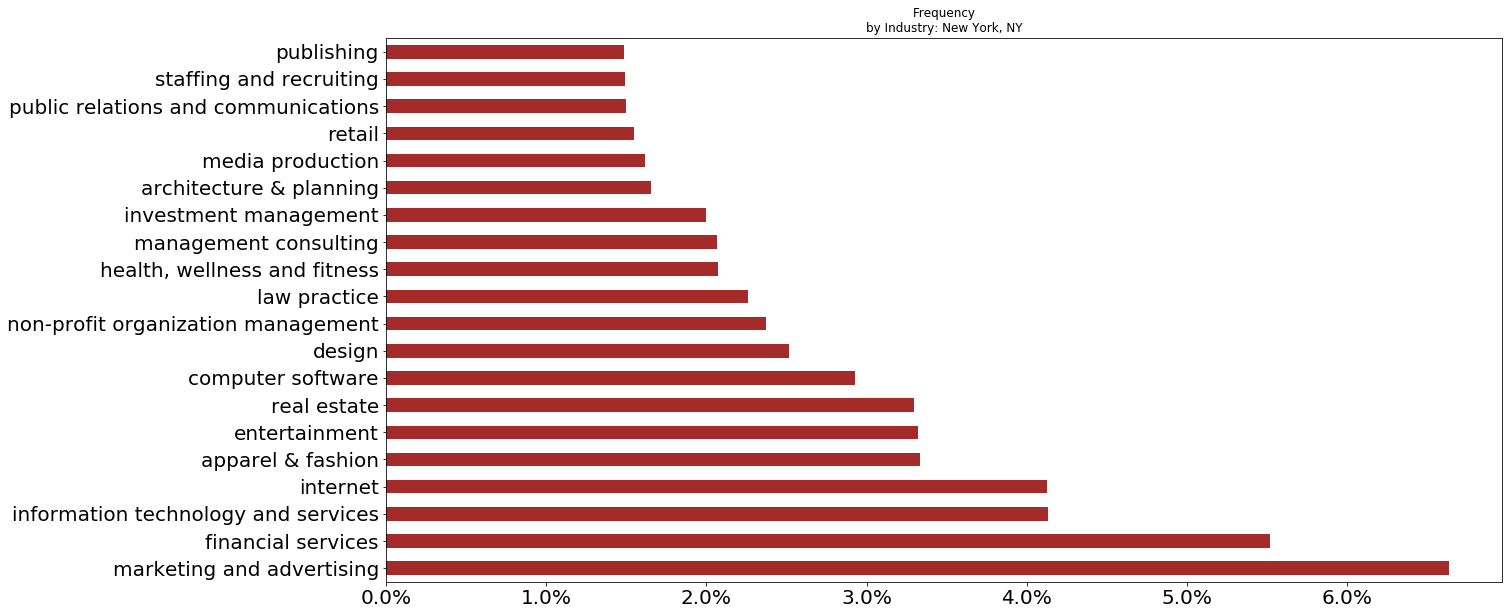

In [208]:
def barchart(data, type, title, limit, figsize, color, normalize=False):
    fig, ax = plt.subplots()
    
    if type == 'vertical':
        ax = data.value_counts(dropna=True, normalize=normalize).head(limit).plot(ax=ax, kind='bar', title = title, figsize = figsize, color=color, fontsize=20)
        if normalize == True:
            ax = ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
        else:
            ax = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    elif type == "horizontal":
        ax = data.value_counts(dropna=True, normalize=normalize).head(limit).plot(ax=ax, kind='barh', title = title, figsize = figsize, color=color, fontsize=20)
        if normalize == True:
            ax = ax.xaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
        else:
            ax = ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
            #ax.tick_params(axis="y", labelsize=20)
    
    return ax

#barchart(df['size range'], 'horizontal', "Frequency\nby Staff Size", 20, [10,6], 'blue', True)
#barchart(df[(df['industry'] == 'construction') & (df['country'] == 'united states')]['locality'], 'horizontal', "Frequency\nby Locality", 20, [20,10], 'navy', False)
#barchart(df[(df['industry'] == 'real estate') & (df['country'] == 'united states')]['locality'], 'horizontal', "Frequency\nby Locality: Management Consulting", 20, [20,10], 'navy', False)

#barchart(df[df['locality'] == 'miami, florida, united states']['size range'], 'horizontal', "Frequency\nby Staff Size: Miami, FL", 20, [20,10], 'blue', True)
#barchart(df[df['locality'] == 'houston, texas, united states']['industry'], 'horizontal', "Frequency\nby Industry: Houston, TX", 20, [20,10], 'green', True)
#barchart(df[df['locality'] == 'chicago, illinois, united states']['industry'], 'horizontal', "Frequency\nby Industry: Chicago, IL", 20, [20,10], 'green', True)
barchart(df[df['locality'] == 'new york, new york, united states']['industry'], 'horizontal', "Frequency\nby Industry: New York, NY", 20, [20,10], 'brown', True)
#barchart(df[df['locality'] == 'phoenix, arizona, united states']['industry'], 'horizontal', "Frequency\nby Industry: Phoenix, AZ", 20, [20,10], 'orange', True)
#barchart(df[df['locality'] == 'seattle, washington, united states']['industry'], 'horizontal', "Frequency\nby Industry: Orlando, FL", 20, [20,10], 'maroon', True)

#barchart(df[df['industry'] == 'real estate']['locality'], 'horizontal', "Frequency\nby Country: Real Estate", 40, [10,20], 'red', True)
print()
#barchart(df[df['country'] == 'united states']['industry'], 'horizontal', "Frequency\nby Industry: United States", 25, [10,10], 'blue', True)
#barchart(df[df['country'] == 'united kingdom']['industry'], 'horizontal', "Frequency\nby Industry: United Kingdom", 25, [10,10], 'orange', True)
#barchart(df[df['country'] == 'india']['industry'], 'horizontal', "Frequency\nby Industry: India", 25, [10,10], 'green', True)
#barchart(df[df['country'] == 'canada']['industry'], 'horizontal', "Frequency\nby Industry: Canada", 25, [10,10], 'black', True)
#barchart(df[df['country'] == 'spain']['industry'], 'horizontal', "Frequency\nby Industry: Spain", 25, [10,10], 'red', True)


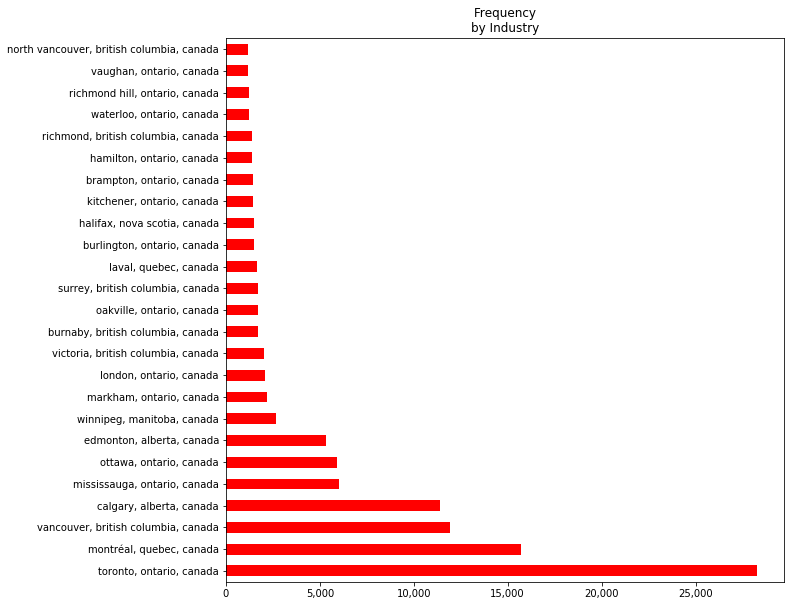

In [181]:
#barchart(df[df['country'] == 'united states']['locality'], 'horizontal', "Frequency\nby Industry", 15, [10,10], 'purple')
#barchart(df[df['country'] == 'united kingdom']['locality'], 'horizontal', "Frequency\nby Industry", 15, [10,10], 'orange')
barchart(df[df['country'] == 'canada']['locality'], 'horizontal', "Frequency\nby Industry", 25, [10,10], 'red')
#barchart(df[df['country'] == 'india']['locality'], 'horizontal', "Frequency\nby Industry", 25, [10,10], 'navy')

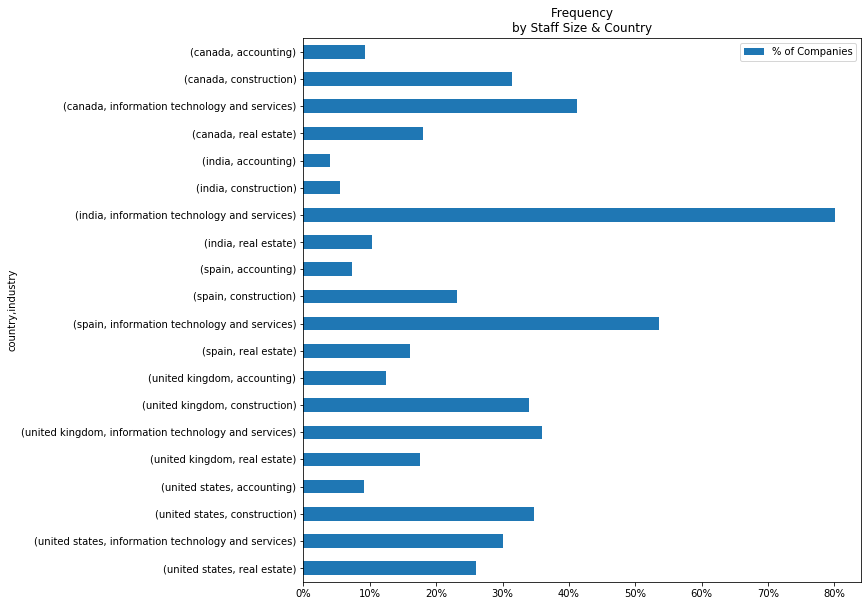

In [14]:

def doublebarchart(df, columns, filtera, filterb, type, title, limit, figsize, color, normalize=False):
    
    if type == 'vertical':
        if normalize == False:
            fig, ax = plt.subplots()
            if filterb is None:
                ax = df[df[columns[0]].isin(filtera)].groupby(columns).size().to_frame('# of Companies').sort_index(level=columns, ascending = [False, False]).head(limit).plot(ax=ax, kind='bar', title = title, figsize = figsize)
            else:
                ax = df[(df[columns[0]].isin(filtera)) & (df[columns[1]].isin(filterb))].groupby(columns).size().to_frame('# of Companies').sort_index(level=columns, ascending = [False, False]).head(limit).plot(ax=ax, kind='bar', title = title, figsize = figsize)
            
            ax = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        else:
            if filterb is None:
                ax = df[df[columns[0]].isin(filtera)].groupby(columns).size()
            else:
                ax = df[(df[columns[0]].isin(filtera)) & (df[columns[1]].isin(filterb))].groupby(columns).size()
            ax = ax.div(ax.sum(level=0), level=0).to_frame('% of Companies').sort_index(level=columns, ascending = [False, False]).head(limit).plot.bar(title = title, figsize = figsize)
            ax = ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
        
    elif type == "horizontal":
        if normalize == False:
            fig, ax = plt.subplots()
            if filterb is None:
                ax = df[df[columns[0]].isin(filtera)].groupby(columns).size().to_frame('# of Companies').sort_index(level=columns, ascending = [False, False]).head(limit).plot(ax=ax, kind='barh', title = title, figsize = figsize)
            else:
                ax = df[(df[columns[0]].isin(filtera)) & (df[columns[1]].isin(filterb))].groupby(columns).size().to_frame('# of Companies').sort_index(level=columns, ascending = [False, False]).head(limit).plot(ax=ax, kind='barh', title = title, figsize = figsize)
             
            ax = ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
            
        else:
            if filterb is None:
                ax = df[df[columns[0]].isin(filtera)].groupby(columns).size()
            else:
                ax = df[(df[columns[0]].isin(filtera)) & (df[columns[1]].isin(filterb))].groupby(columns).size()
            ax = ax.div(ax.sum(level=0), level=0).to_frame('% of Companies').sort_index(level=columns, ascending = [False, False]).head(limit).plot.barh(title = title, figsize = figsize)
            ax = ax.xaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
        
        
    return ax

#doublebarchart(df, ['industry', 'size range'], ['information technology and services', 'construction', 'information technology and services', 'accounting', 'real estate'], None, 'horizontal', "Frequency\nby Staff Size & Industry", 100, [10,10], 'blue', False)
#doublebarchart(df, ['industry', 'size range'], ['information technology and services', 'construction', 'information technology and services', 'accounting', 'real estate'], None, 'horizontal', "Frequency\nby Staff Size & Industry", 100, [10,10], 'blue', True)

print()
#doublebarchart(df, ['country', 'size range'], ['united states', 'united kingdom', 'canada', 'india', 'spain'], None, 'horizontal', "Frequency\nby Staff Size & Country", 100, [10,10], 'blue', True)
#doublebarchart(df, ['country', 'size range'], ['united states', 'united kingdom', 'canada', 'india', 'spain'], None, 'horizontal', "Frequency\nby Staff Size & Country", 100, [10,10], 'blue', True)
doublebarchart(df, ['country', 'industry'], ['united states', 'united kingdom', 'canada', 'india', 'spain'], ['information technology and services', 'construction', 'information technology and services', 'accounting', 'real estate'], 'horizontal', "Frequency\nby Staff Size & Country", 100, [10,10], 'blue', True)

In [146]:
df['industry'].describe()

count                                 6883423
unique                                    148
top       information technology and services
freq                                   453044
Name: industry, dtype: object

In [213]:
n = 20
print(df['industry'].value_counts()[:n].index.tolist())
#print(df['industry'].value_counts()[:n].values.tolist())

['information technology and services', 'marketing and advertising', 'missing', 'construction', 'management consulting', 'real estate', 'computer software', 'internet', 'financial services', 'health, wellness and fitness', 'hospital & health care', 'education management', 'retail', 'design', 'automotive', 'non-profit organization management', 'hospitality', 'food & beverages', 'accounting', 'entertainment']


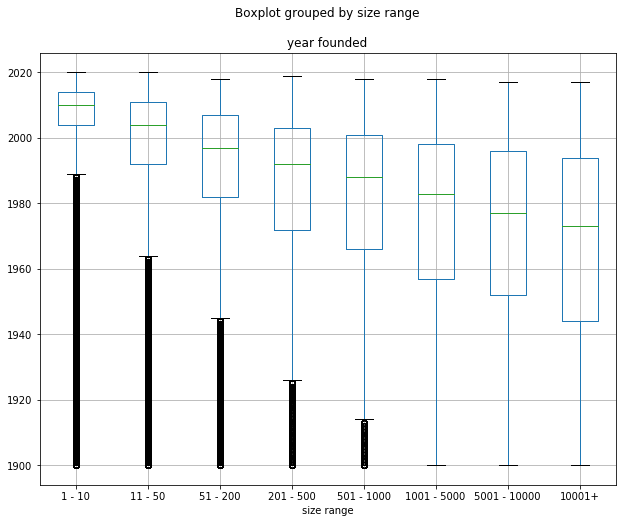

In [156]:
df[(df['year founded'] >= 1900) & (df['year founded'] < 2021)].boxplot('year founded','size range',figsize = (10,8))

In [174]:
print(df[df['size range'] == '1 - 10']['year founded'].describe().apply("{0:f}".format))
print()
print(df[df['size range'] == '11 - 50']['year founded'].describe().apply("{0:f}".format))

count    2538671.000000
mean        2005.523805
std           15.882539
min         1775.000000
25%         2003.000000
50%         2010.000000
75%         2014.000000
max         2103.000000
Name: year founded, dtype: object

count    720020.000000
mean       1996.681907
std          23.386875
min        1775.000000
25%        1992.000000
50%        2004.000000
75%        2011.000000
max        2023.000000
Name: year founded, dtype: object


In [237]:
industries = df[df['industry'] != 'missing']['industry'].value_counts()[:n].index.tolist()

#print(df[df['industry'].isin(industries)].groupby(['locality','industry']).size().unstack('industry', fill_value=0).sort_values(by='construction', ascending=False))
corr_df = df[(df['industry'].isin(industries)) & (df['country'] == 'united states')].groupby(['locality','industry']).size().unstack('industry', fill_value=0).sort_values(by='construction', ascending=False).corr()


In [248]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5, setting = 0):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    if setting == 0:
        return au_corr[0:n]
    else:
        return au_corr[-n:]

#print("Top Absolute Correlations")
#print(get_top_abs_correlations(corr_df, , 0))
get_top_abs_correlations(corr_df, 500, 0).to_csv('datasets/correlation.csv', header=True)